In [102]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

в качестве оценки качества будем использовать RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

In [103]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

###  1. Ряд с количеством регистраций автомобилий в США

In [5]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep= ';')
df.columns = ['Month','Count']

series_raw = df['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


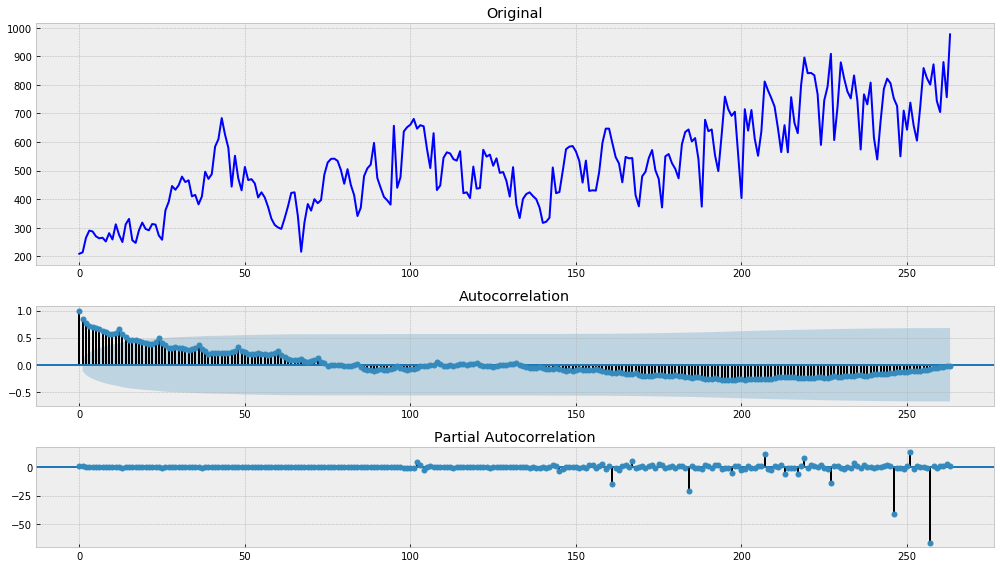

In [6]:
tsplot(series_raw)

1. уберем изменение дисперсии при помощи преобразования Бокса-Кокса
2. уберем тренд через дифференцирование
3. уберем сезональность через повтороное дифференцирование

In [7]:
#1
series_stat = boxcox(series_raw, 0)

In [8]:
#2
series_stat = series_stat[1:] - series_stat[:-1]

In [9]:
#3
series_stat = series_stat[12:] - series_stat[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


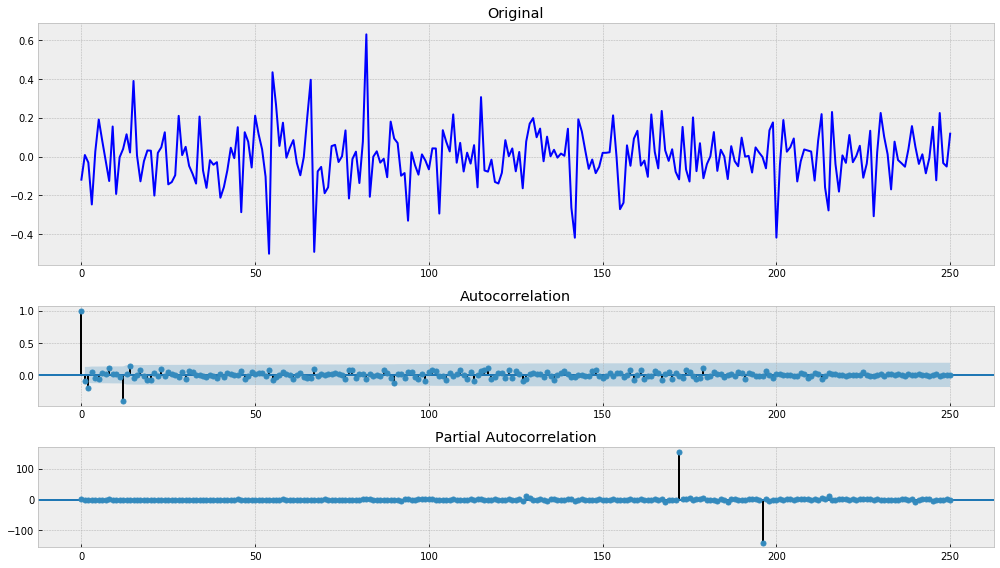

In [10]:
# и визуально и по p-level ряд стал стационарным
tsplot(series_stat)

#### Задание: 
приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

Перечислим, какие у нас есть варианты:
- a) Скользящее среднее
- b) Взвешенное скользящее среднее
- c) Взвешенное экспоненциально скользящее среднее
- d) Двойное экспоненциальное сглаживание
- e) Тройное экспоненциальное сглаживавние Хольта-Винтерса

### I. Начнем с более простого - со стационарного ряда

In [13]:
train_stat, test_stat = pd.Series(series_stat[:200]), pd.Series(series_stat[200:])

a) Скользящее среднее - прогноз получился практически везде равным среднему, как и должно быть для стационарного ряда по его определению

In [14]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [100]:
series_pred = predict(train_stat, 10, 51)
error = mean_squared_error(series_pred[-51:], test_stat)

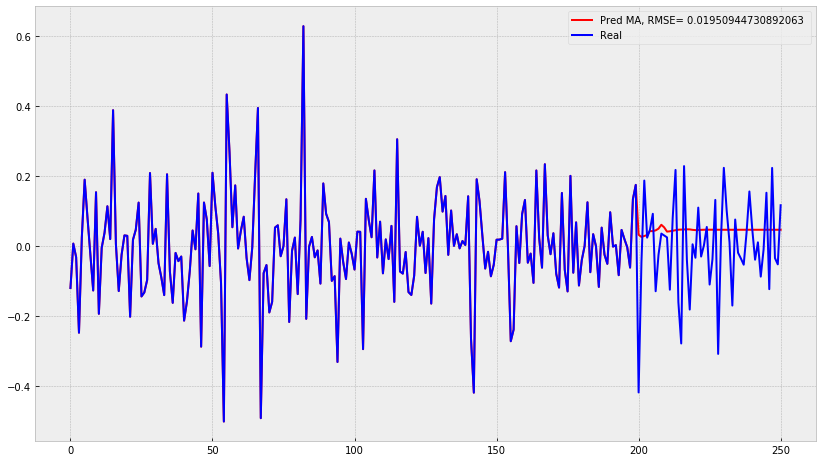

In [101]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred MA, RMSE= {} '.format(error))
    plt.plot(series_stat, color='blue', linewidth='2', label='Real')
    plt.legend()

b) Взвешенное скользящее среднее - по RMSE прогноз немного хуже обычного скользящего среднего.

In [20]:
def predict_wma(series, n, n_pred, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    new_series = series.copy()
    
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([(new_series[-n:]*weights).sum()/weights.sum()]), ignore_index=True)
    return new_series

In [21]:
series_pred = predict_wma(train_stat, 7, 51,[1,1,2,3,5,8,13])
error = mean_squared_error(series_pred[-51:], test_stat)

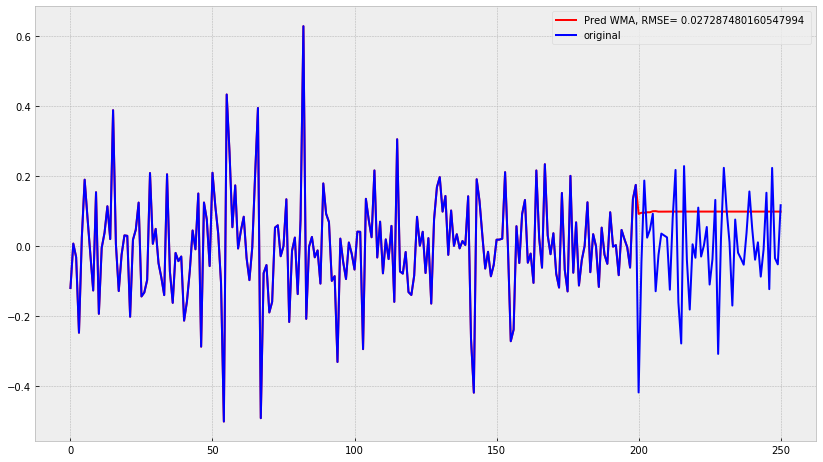

In [22]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred WMA, RMSE= {} '.format(error))
    plt.plot(series_stat, color='blue',label='original')
    plt.legend()

c) Взвешенное экспоненциально скользящее среднее - лучший по RMSE прогноз

In [23]:
def predict_ema(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True)

In [24]:
series_pred = predict_ema(train_stat, 0.1, 51)
error = mean_squared_error(series_pred[-51:], test_stat)

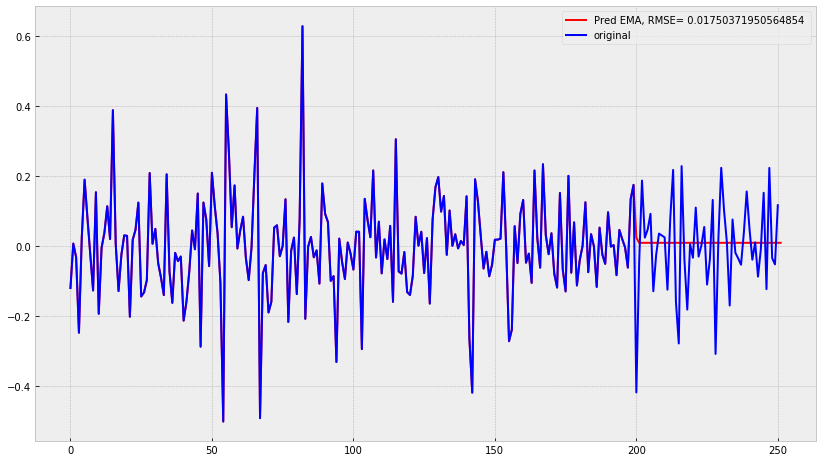

In [25]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred EMA, RMSE= {} '.format(error))
    plt.plot(series_stat, color='blue',label='original')
    plt.legend()

d) Двойное экспоненциальное сглаживание - прогноз бредовый, т.к. ряд стационарный

In [29]:
def predict_double_ema(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True)

In [30]:
series_pred = predict_double_ema(train_stat, 0.5, 0.15, 51)
error = mean_squared_error(series_pred[-51:], test_stat)

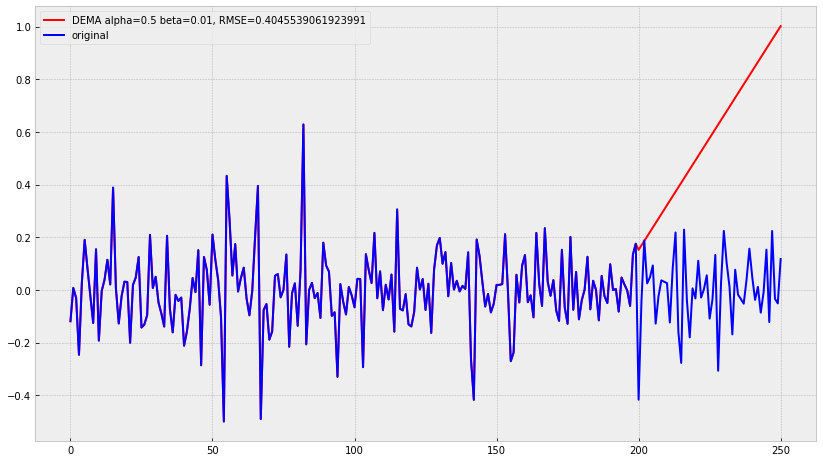

In [31]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='DEMA alpha={} beta={}, RMSE={}'.format(0.5, 0.01,error))
    plt.plot(series_stat, color='blue',label='original')
    plt.legend()

e) Хольт-Винтерс - неудачный прогноз, т.к. он предназначен для ряда с трендом, сезонностью, а стационарный от всего очищен.

In [32]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [33]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [34]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [35]:
def plot_tema(alpha, beta, gamma, ser=train_stat, ser_to_plot=series_stat, n_preds=51):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    error = mean_squared_error(tema[-n_preds:], test_stat)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA , RMSE={}'.format(error))
        plt.title("alpha={}, beta={}, gamma={}, RMSE={}".format(alpha, beta, gamma, error))
        plt.legend()
        

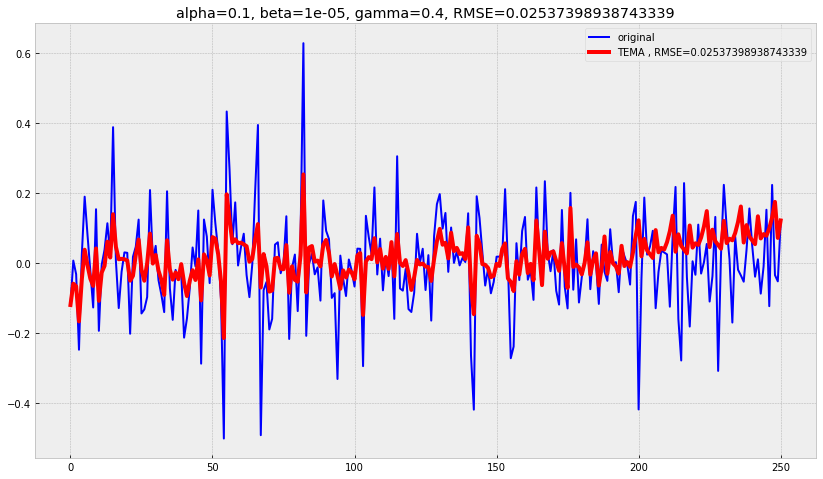

In [36]:
plot_tema(0.1, 0.00001, 0.4)

### ВЫВОД 1: для стационарного ряда лучше всего подходит  - экспоненциальное скользящее среднее, чтобы учитывались все значения ряда, а не только последние, в которых могут быть выбросы

### II. Перейдем теперь к нестационарному ряду

a) Скользящее среднее - прогноз не учитывает тренд и колебания

In [37]:
train_raw, test_raw = pd.Series(series_raw[:200]), pd.Series(series_raw[200:])

In [40]:
series_pred = predict(train_raw, 10, 64)
error = mean_squared_error(series_pred[-64:], test_raw)

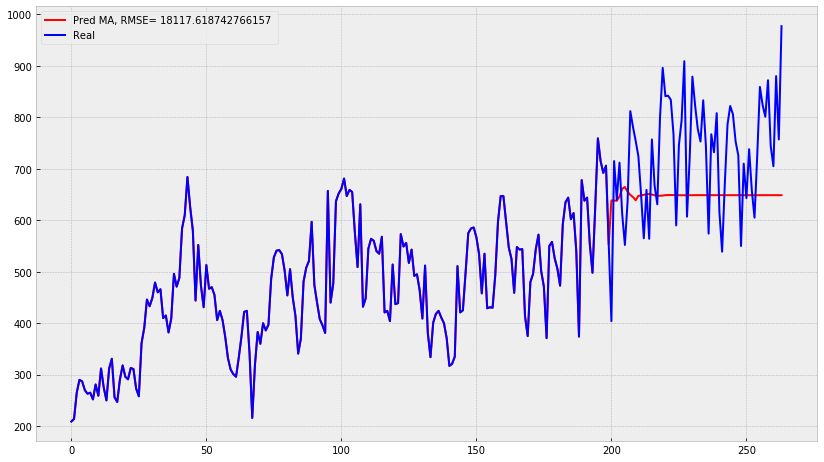

In [42]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred MA, RMSE= {} '.format(error))
    plt.plot(series_raw, color='blue', linewidth='2', label='Real')
    plt.legend()

b) Взвешенное скользящее среднее - по RMSE прогноз немного хуже обычного скользящего среднего, также не учитывается тренд и колебания.

In [46]:
series_pred = predict_wma(train_raw, 7, 64,[1,1,2,3,5,8,13])
error = mean_squared_error(series_pred[-64:], test_raw)

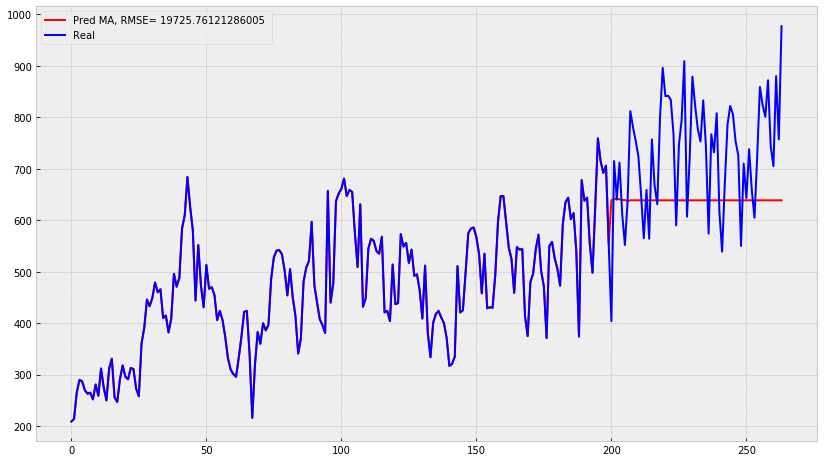

In [48]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred MA, RMSE= {} '.format(error))
    plt.plot(series_raw, color='blue', linewidth='2', label='Real')
    plt.legend()

c) Взвешенное экспоненциально скользящее среднее - худший по RMSE прогноз, т.к. учитывает всю историю, которая не релевантна для тренда

In [51]:
series_pred = predict_ema(train_raw, 0.1, 64)
error = mean_squared_error(series_pred[-64:], test_raw)

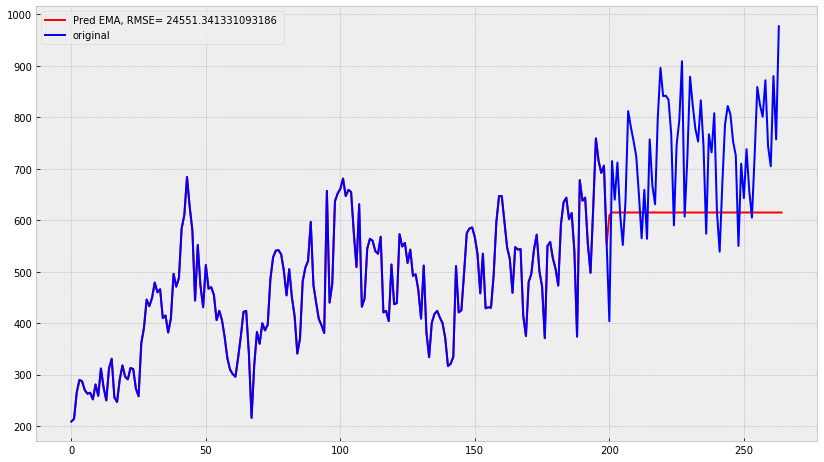

In [52]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='Pred EMA, RMSE= {} '.format(error))
    plt.plot(series_raw, color='blue',label='original')
    plt.legend()

d) Двойное экспоненциальное сглаживание - первый относительно адекватный прогноз

In [66]:
series_pred = predict_double_ema(train_raw, 0.5, 0.01, 64)
error = mean_squared_error(series_pred[-64:], test_raw)

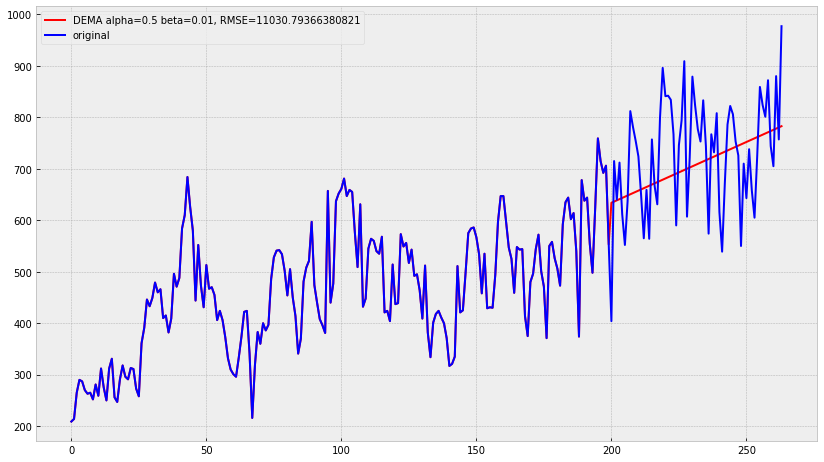

In [68]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='red', linewidth='2', label='DEMA alpha={} beta={}, RMSE={}'.format(0.5, 0.01,error))
    plt.plot(series_raw, color='blue',label='original')
    plt.legend()

e) Хольт-Винтерс - самый точный вариант приближения по RMSE (5 тыс.), что почти в 5 раз лучше RMSE экспоненциально взвешенного скользящего среднего (25 тыс.)

In [73]:
def plot_tema(alpha, beta, gamma, ser=train_raw, ser_to_plot=series_raw, n_preds=64):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    error = mean_squared_error(tema[-n_preds:], test_raw)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='3', label='TEMA , RMSE={}'.format(error))
        plt.title("alpha={}, beta={}, gamma={}, RMSE={}".format(alpha, beta, gamma, error))
        plt.legend()
        

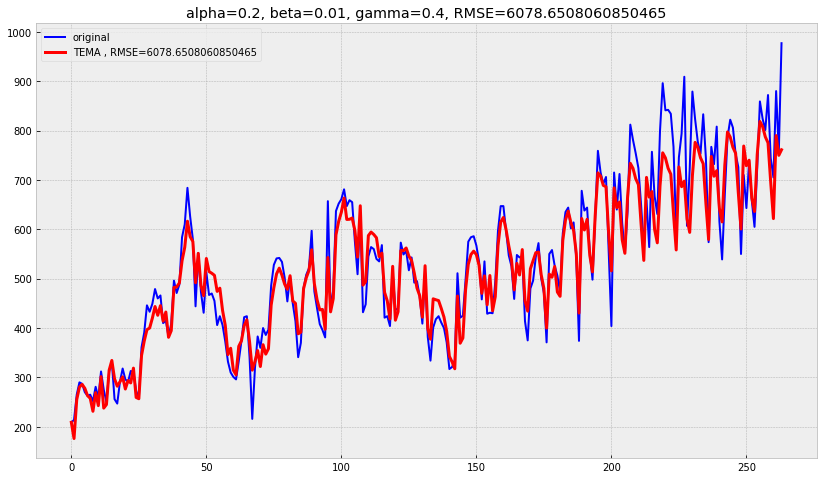

In [84]:
plot_tema(0.2, 0.01, 0.4)

Подберем гипер-параметры, минимизирующие RMSE

In [95]:
train, test = series_raw[:200], series_raw[200:]

In [96]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [97]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [98]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5005.9754158695805
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00854925, -0.12105374,  0.00109139])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 30
   status: 0
  success: True
        x: array([0.14073552, 0.02722669, 0.38572841])


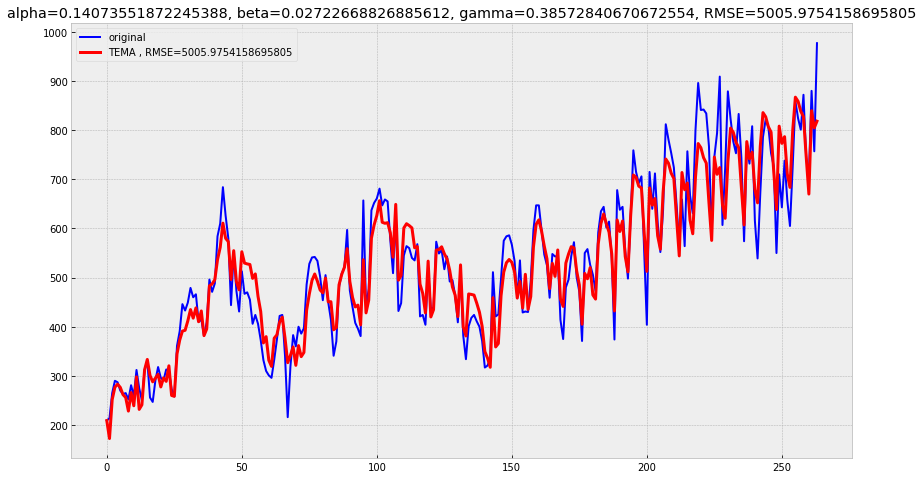

In [99]:
plot_tema(alpha_opt, beta_opt, gamma_opt)

### ВЫВОД 2: для нестационарного ряда лучше всего подходит тройное экспоненциальное сглаживание Хольта-Винтерса, который умеет улавливать тренд, сезонность, уровень.